In [1]:
import os
import re
import json
from tqdm.notebook import tqdm
from textwrap import dedent

import numpy as np
import pandas as pd
from scipy import ndimage
from scipy import optimize 
from sklearn.preprocessing import MinMaxScaler, PowerTransformer

import matplotlib.pyplot as plt

import utils

def scatter(w, k):
    return k * (1 / w**4)

def r_squared(y, y_hat):
    residuals = y - y_hat
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y-np.mean(y))**2)
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared


root_dir_walk = os.walk('..')

plate_files = []

experiment_configs = {}

for dirpath, dirnames, filenames in root_dir_walk:
    if (e := re.search('\.\./([0-9]+)', dirpath)) is not None:
        experiment_number = int(e.group(1))
        data = {}
        if 1 <= experiment_number <= 22:
            if experiment_number not in experiment_configs.keys():
                for filename in filenames:
                    fpath = os.path.join(dirpath, filename)
                    if filename.split('.')[-1] == 'CSV' and 'pathlength' not in filename.lower():
                        plate_files.append(fpath)
                    if re.search('experiment-[0-9]+-summary\.csv', filename) is not None:
                        data['summary_fname'] = filename 
                        data['summary_path'] = fpath
                    if re.search('config\_[0-9]+\.json', filename) is not None:
                        data['config_fname'] = filename 
                        with open(fpath, 'r') as f:
                            data['config'] = json.load(f)
                if data != {}:
                    experiment_configs[experiment_number] = data

configs_df = pd.concat([pd.read_csv(experiment_configs[i]['summary_path']) for i in experiment_configs]).reset_index(drop=True)

In [2]:
df = pd.concat([utils.bmg.parse_bmg(i) for i in plate_files])

df_corr = df.subtract(df[800], axis=0)

df_clear = df_corr.loc[df_corr[280] < 1, :]
df_normal = df_corr.loc[df_corr[280] > 1, :]

In [3]:
sorted([i for i in experiment_configs.keys() if 'experiments' not in experiment_configs[i]['config'].keys()])

[]

In [4]:
experiment_configs[4]['config']['experiments']

{'plate_1': {'file': 'data/20190618_Assay2.csv',
  'plate_type': 'Thermo Polystyrene (262160)',
  'columns': {'13': 'DMSO',
   '14': 'Lauric acid',
   '15': 'Lauric acid',
   '16': 'Arachadionic acid',
   '17': 'Arachadionic acid',
   '18': '4-Phenylimidazole',
   '19': '4-Phenylimidazole'}}}

## Trim $A < 300$

In [5]:
df_normal = df_normal.loc[:, 300:]



## Zero Traces at 800 nm

Commonly, traces are transformed in the $A$ direction by an amount equal to $A_{800}$

This is because of?

Join configs to traces

Uniformly subtracting $A_{800}$ from each trace cancels this effect, which has precedent?

## Distribution:

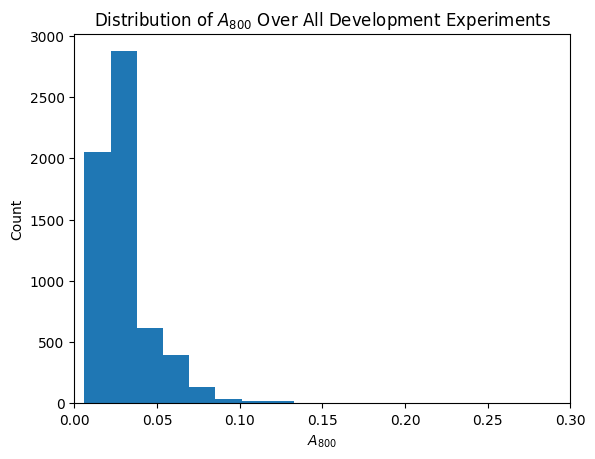

In [6]:
plt.hist(df[800], bins=100)
plt.xlim(0, 0.3)
plt.xlabel('$A_{800}$')
plt.ylabel('Count')
plt.title('Distribution of $A_{800}$ Over All Development Experiments')
plt.show()

## Figure: Before and After $A_{800}$ Normalization

In [7]:
df_normal_smooth = pd.DataFrame(ndimage.gaussian_filter1d(df_normal, 
                                                          sigma=5,
                                                          axis=1,), 
                                columns=df_normal.columns, 
                                index=df_normal.index,
                               )

df_normal_smooth =  df_normal_smooth.subtract(df_normal_smooth[800], axis=0)

# auc_smooth = np.trapz(df_normal_smooth, axis=1)
# _auc_norm_smooth = auc_smooth - min(auc_smooth)
# auc_norm_smooth = _auc_norm_smooth / max(_auc_norm_smooth)

## Smooth Traces

Following steps include subtraction of blank wells, where small random noise can interfere.
Smoothing the traces with Guassian smoothing mitigates the effects of the noise whilst preserving the macro 
features of interest (the P450 peaks)

## Figure: Before and After Smoothing

Or different $\sigma$ paramaters for comparison - need to justify a choice for $\sigma$

## AUC

In [8]:
auc = np.trapz(df_normal, axis=1)
_auc_norm = auc - min(auc)
auc_norm = _auc_norm / max(_auc_norm)


auc_smooth = np.trapz(df_normal_smooth, axis=1)
_auc_norm_smooth = auc_smooth - min(auc_smooth)
auc_norm_smooth = _auc_norm_smooth / max(_auc_norm_smooth)


## Baseline Subtraction

- Each individual trace and corresponding control
- Ideal Baseline - presumed plate inherent absorbance

In [9]:
baseline = df_normal.iloc[auc.argmin(), :]
sigma = 5
baseline_smooth = pd.Series(ndimage.gaussian_filter1d(baseline, sigma=sigma), index=baseline.index)
baseline_smooth -= baseline_smooth[800]

baseline = df_normal_smooth.iloc[auc_norm_smooth.argmin(), :]

df_normal_smooth = df_normal_smooth - baseline_smooth

## Scattering Curve Fitting

In [10]:
# all_rsq = []
# all_k = []
# 
# for i in tqdm(range(len(df_normal_smooth))):
#     row = df_normal_smooth.iloc[i, :]
#     k, cov = optimize.curve_fit(scatter,
#                                 xdata=row.index,
#                                 ydata=row
#                                )
#     y_pred = pd.Series(scatter(row.index, k), index=row.index)
#     rsq = r_squared(row, y_pred)
#     all_rsq.append(rsq)
#     all_k.append(k)
#     
# ks = np.concatenate(all_k).reshape(-1, 1)
# rsqs = np.array(all_rsq)
# 
# mm_scaler = MinMaxScaler()
# mm_scaler.fit(ks)
# power_scaler = PowerTransformer()
# power_scaler.fit(ks)
# 
# def color_k(k):
#     k_norm = power_scaler.transform(np.array(k).reshape(1,1)).flatten()
#     return plt.cm.inferno(k_norm)
#     
# metrics_df = pd.DataFrame([ks.flatten(), rsqs.flatten()], index=['K', 'Rsq']).T
# metrics_df_kslice = metrics_df.loc[metrics_df['Rsq'] > 0, :]
# 
# df_normal_smooth_kslice = df_normal_smooth.iloc[metrics_df_kslice.index, :]

## Exclusion Threshold

In [11]:
configs_df.T

,0,1,2,3,4,5,6,7,8,9,...,1072,1073,1074,1075,1076,1077,1078,1079,1080,1081
ligand,NaN,Arachadionic Acid,Arachadionic Acid,Arachadionic Acid,Arachadionic Acid,Arachadionic Acid,Arachadionic Acid,Arachadionic Acid,Arachadionic Acid,Arachadionic Acid,...,4-Phenylimidazole,NaN,NaN,Arachadionic Acid,Arachadionic Acid,Lauric Acid,Lauric Acid,Palmitic Acid,Palmitic Acid,4-Phenylimidazole
km,1.53895,285.406633,337.546311,261.523179,265.911556,379.27758,310.289539,412.596821,520.16094,322.986917,...,195.26606,6.753271,0.000008,93.344497,88.937568,30.385708,42.02934,10.039077,4.367263,0.860649
vmax,0.01251,0.079279,0.083692,0.082059,0.077865,0.086277,0.071257,0.086655,0.100571,0.070948,...,0.20138,0.034092,0.007857,0.348294,0.351034,0.089304,0.081279,0.014703,0.017393,0.004267
rsq,0.021696,-2.393192,-2.341006,-2.433887,-2.452384,-2.275981,-2.268667,-2.352184,-2.344829,-2.303432,...,-2.700598,-2.139874,-0.135748,-2.67894,-2.637802,-2.58336,-2.679207,-1.073942,-1.133242,-0.377019
column_num,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,24.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
protein_concentration,4.01,4.01,4.01,4.01,4.01,4.01,4.01,4.01,4.01,4.01,...,15.0,15.14,15.14,15.14,15.14,15.14,15.14,15.14,15.14,15.14
a420_max,0.093,0.08,0.083,0.082,0.081,0.081,0.075,0.078,0.079,0.071,...,0.567,0.263,0.359,0.328,0.335,0.345,0.358,0.346,0.355,0.297
auc_mean,8.606125,10.5975,8.540825,8.798688,8.220812,8.226187,5.509688,8.218438,8.947,7.667,...,84.027875,20.32525,28.954188,31.641687,33.316,29.895125,29.987687,27.6845,29.113313,29.281313
auc_cv,0.575958,0.443524,0.461805,0.503424,0.391866,0.569615,0.415251,0.653151,0.525326,0.67413,...,0.049139,0.131146,0.148654,0.110876,0.102972,0.082169,0.0899,0.069704,0.150287,0.16947
std_405,0.008799,0.012873,0.0055,0.005182,0.005153,0.006437,0.004928,0.003662,0.003926,0.004899,...,0.045844,0.009739,0.009819,0.015182,0.012221,0.008697,0.011042,0.004342,0.006022,0.005928
